## Transfer learning usingVGG Net

In [1]:
%matplotlib inline
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
import numpy as np
from keras.utils import np_utils
from keras import backend as K


K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [3]:
#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

model_vgg16_conv.trainable = False
#Create your own input format (here 3x200x200)

input = Input(shape=(32,32,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

#Add the fully-connected layers 
dropout = 0.5
x = Flatten(name='flatten',input_shape=(512,1,1))(output_vgg16_conv)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(dropout)(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(4, activation='softmax', name='predictions')(x)

#Create your own model 
my_model = Model(input=input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()
my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Then training with your data ! 

for layer in my_model.layers[:2]:
    layer.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

/home/kriti/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("im...)`


## Preprocessing data

In [16]:
from PIL import Image
import os
import numpy as np
from os import listdir
from scipy.misc import imshow
import scipy.misc
from numpy import *
import PIL

size = 32
def preprocess_image(infilename,size):
    data = Image.open(infilename)#.convert('L')
#     data = scipy.misc.imread(infilename, mode = "L")
    data.thumbnail((size,size), Image.ANTIALIAS)
    img = data.resize((size,size))
    scipy.misc.imsave("test-file-vgg.jpg", img)
    
def load_image( infilename ) :
    preprocess_image(infilename,size)
    data = scipy.misc.imread("test-file-vgg.jpg", mode = "RGB")   
    return data

path = ['Dataset/test_images/memes','Dataset/test_images/greetings','Dataset/test_images/scanned_images','Dataset/test_images/test_imp_images']
Y = []
X = []
data = []

for p in path:
    for files in listdir(p):
        try:
            t = load_image(p+'/'+files)
            X = t
            Y = (float(path.index(p)))
            data.append((X,Y,p+'/'+files))
        except:
            print("error reading file:"+ files)

In [90]:
classes_dict = {}
classes_dict[0] = 'Memes'
classes_dict[1] = 'Greetings'
classes_dict[2] = 'Scanned Documents'
classes_dict[3] = 'Miscellaneous'

In [25]:
#Xtemp = np.uint8(X)
import random
import matplotlib.pyplot as plt
random.shuffle(data)
imageNameDict = {}
X = []
Y = []

for d in data:
    X.append(d[0])
    Y.append(d[1])
    imageNameDict[len(X)-1]=d[2]

In [26]:
image_size = 32
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
totalSize = len(X)

# load data
X_test = np.array(X)
y_test = np.array(Y)
X_test = X_test / 255.0

# one hot encode outputs
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

## Sanity Check

In [28]:
# print(X_test[0].shape)
# print(len(X_test))

(32, 32, 3)
77


## Fit the new model

In [29]:
from keras.callbacks import History 
history = History()

In [30]:

weights_file = 'models/vgg_exp1.h5'
# if not os.path.exists(weights_file):
#     my_model.compile(optimizer = 'adam',loss= 'categorical_crossentropy', metrics = ['accuracy'])
#     my_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=200, callbacks = [history])    
#     my_model.save_weights(weights_file)
# else:
my_model.load_weights(weights_file)


## Plots

In [31]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# acc = history.history['acc']
# val_acc = history.history['val_acc']

# # my_model.save_weights(weights_file)

# import matplotlib.pyplot as plt
# def plot(label1,label2,xlabel,ylabel):
#     X_axis = range(1,len(acc)+1)
#     plt.plot(X_axis, acc, marker='o', linestyle='-', color='g',label=xlabel)
#     plt.plot(X_axis, val_acc, marker='o', linestyle='--', color='r',label=ylabel)
#     plt.xlabel(label1)
#     plt.ylabel(label2)
#     legend = plt.legend(loc='lower right', shadow=True)
#     plt.show()

In [32]:
# plot('No. of epochs','Accuracy',"Train Accuracy","Test Accuracy")

## Confusion Matrix

77/77 [==============================] - 1s     
[[16  1  0  3]
 [ 1 17  0  2]
 [ 0  0 20  0]
 [ 0  0  0 17]]


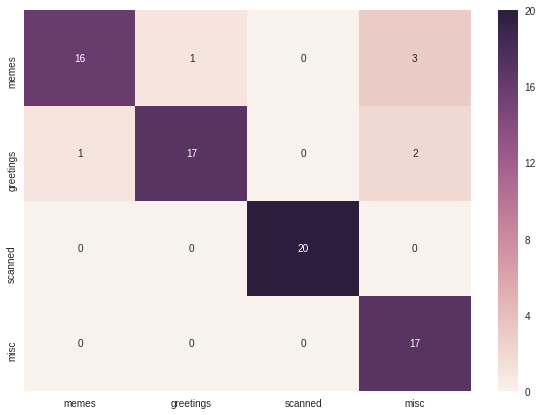

In [98]:
import numpy as np
predict = my_model.predict(X_test, verbose=1)
predict1 = np.argmax(predict,axis=1)
y_test1 = np.argmax(y_test,axis=1)
image_prediction = {}
for k,v in enumerate(predict1):
    image_prediction[imageNameDict[k]] = predict1[v]

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test1,predict1)
print(cm)
sn.set()
import matplotlib.pyplot as plt
%matplotlib inline
# plt.imshow(cm, cmap='binary')
pd.options.display.float_format = '{:.2f}'.format
categories = ["memes",'greetings','scanned','misc']
np.set_printoptions(suppress=True)
df_cm = pd.DataFrame(cm, index = [i for i in categories],
                  columns = [i for i in categories])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt="d")

In [99]:
misclassified = np.where(y_test1 != predict1)

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline  
misclassified_files = []
for v in misclassified[0]:
    print(imageNameDict[v])
    misclassified_files.append(imageNameDict[v])

Dataset/test_images/memes/1a8wln.jpg
Dataset/test_images/memes/1aat8r.jpg
Dataset/test_images/greetings/etings-7.jpg
Dataset/test_images/greetings/etings-10.jpg
Dataset/test_images/greetings/etings-14.jpg
Dataset/test_images/memes/1a8zpe.jpg
Dataset/test_images/memes/1aacgq.jpg


Predicted Label:Miscellaneous
Correct Label:Memes


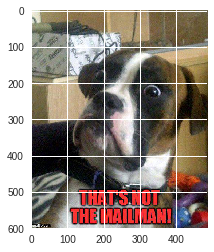

In [101]:
img_index = 0
img = Image.open(misclassified_files[img_index])
plt.imshow(img)
p_label = classes_dict[predict1[int(misclassified[0][img_index])]]
c_label = classes_dict[y_test[int(misclassified[0][img_index])].tolist().index(1.0)]
print("Predicted Label:"+ p_label)
print("Correct Label:"+ c_label)

In [102]:
# save to file:
import json
with open('output1.json', 'w') as f:
    json.dump(image_prediction, f)

In [104]:
output1

NameError: name 'output1' is not defined